In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))

In [2]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

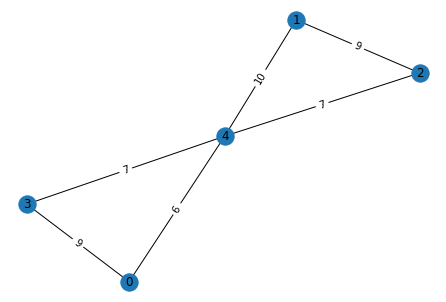

In [4]:
# ---- Define graph and MaxCut ----
graph = generate_butterfly_graph(with_weights=True)
#graph = load_nx_graph_from("/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/data/graphs/16_nodes/graph_16_33_01_w.txt")

max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [5]:
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer

In [9]:
quantum_instance = QuantumInstance(
                    backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    shots=SHOTS
)

In [16]:
BACKEND_NAME = 'ibmq_toronto'
provider = qiskit.IBMQ.get_provider(hub='ibm-q-unibw', group='hochschule-muc', project='masterarbeit')
noise_backend = provider.get_backend(BACKEND_NAME)
noise_model = NoiseModel.from_backend(noise_backend)
coupling_map = noise_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [17]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
quantum_instance_noise = QuantumInstance(
                backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                shots=SHOTS,
                noise_model=noise_model,
                coupling_map=coupling_map,
                basis_gates=basis_gates,
                measurement_error_mitigation_cls=CompleteMeasFitter,
                measurement_error_mitigation_shots=SHOTS
)

In [31]:
qaoa = QAOA(optimizer=COBYLA(maxiter=10),
            quantum_instance=quantum_instance,
            reps=1,
            initial_point=[0.25, 0.25]
           )

In [32]:
algorithm = MinimumEigenOptimizer(qaoa)
#optimizer = RecursiveMinimumEigenOptimizer(algorithm, history=IntermediateResult.ALL_ITERATIONS)
#result = optimizer.solve(max_cut_qubo)

In [33]:
admm_params = ADMMParameters(
                            rho_initial=1001, 
                            beta=1000, 
                            factor_c=900,
                            maxiter=100,
                            three_block=True, tol=1.e-6
                        )

In [39]:
from qiskit_optimization.algorithms import CobylaOptimizer, MinimumEigenOptimizer

# define QUBO optimizer
qubo_optimizer = algorithm
# qubo_optimizer = cplex  # uncomment to use CPLEX instead

# define classical optimizer
convex_optimizer = CobylaOptimizer()
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(params=admm_params, 
                     qubo_optimizer=qubo_optimizer,
                     continuous_optimizer=convex_optimizer)

qb = max_cut_qubo.to_docplex()

In [40]:
qb

docplex.mp.Model['Max-cut']

In [41]:
result = admm.solve(max_cut_qubo)

In [42]:
optimal_parameters = qaoa.optimal_params
print(f"Optimal Parameters: {optimal_parameters}")

Optimal Parameters: [1.27136633 0.3087344 ]


optimal function value: 0.0
optimal value: [0. 0. 0. 0. 0.]
status: SUCCESS
00000: value: 0.000, probability: 100.0%
Expectation Value: 0.0
Highest Exp.Value: 0 with 1.0
Lowest Exp.Value: 0 with 1.0
Highest Probability: 0 with 1.0
Ratio r: nan
MSE: 0.0
RMSE: 0.0


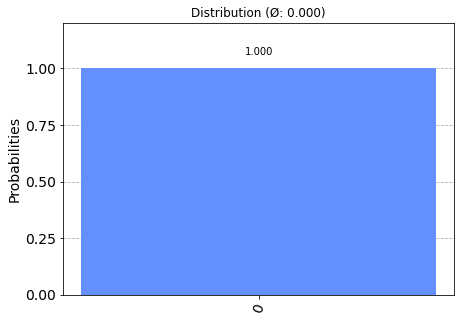

In [43]:
mean, distribution = max_cut.analyse(result, print_output=True)
max_cut.plot_histogram(distribution, mean)